In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# sklearn :: models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set_style('whitegrid')

# Problem definition

Apply classification models to predict customers default payments

# Load the data

In [2]:
#source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
df_original = pd.read_csv('data/default of credit card clients.csv')
df = df_original.copy()
print(df.columns)
df.head()

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
# TODO: check for NaNs
df.isnull().sum(axis = 0)

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_1                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

# Feature Engineering 

In [4]:
# TODO: remove a confusing column
del df['ID']

In [5]:
# TODO: create a loop to transform the categorical columns to numerical
for col in ['SEX', 'EDUCATION', 'MARRIAGE']:
    df_dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, df_dummies], axis=1)
    # Remove the original columns
    del df[col]
df.head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,1,0,0,0,0,0,1,0,0
1,120000,26,-1,2,0,0,0,2,2682,1725,...,0,1,0,0,0,0,0,0,1,0
2,90000,34,0,0,0,0,0,0,29239,14027,...,0,1,0,0,0,0,0,0,1,0
3,50000,37,0,0,0,0,0,0,46990,48233,...,0,1,0,0,0,0,0,1,0,0
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,0,1,0,0,0,0,0,1,0,0


In [6]:
# feature engineering
X_columns = [x for x in df.columns if x != 'default payment next month']
y_column = ['default payment next month']

In [7]:
list(X_columns)

['LIMIT_BAL',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'SEX_1',
 'SEX_2',
 'EDUCATION_0',
 'EDUCATION_1',
 'EDUCATION_2',
 'EDUCATION_3',
 'EDUCATION_4',
 'EDUCATION_5',
 'EDUCATION_6',
 'MARRIAGE_0',
 'MARRIAGE_1',
 'MARRIAGE_2',
 'MARRIAGE_3']

# Model Training

In [8]:
# split the data

threshold = 0.8
X = df[X_columns]
y = df[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (24000, 33)
y_train (24000, 1)
X_test (6000, 33)
y_test (6000, 1)


# Model Training / Evaluation - Using Split

In [9]:
models = [
    ('Naive Bayes', GaussianNB()),
    ('RandomForestClassifier10', RandomForestClassifier(n_estimators=10)),
    ('RandomForestClassifier100', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier())    
]
results = []
for m in models:
    print('MODEL', m[0])
    model = m[1]
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print('Precision', precision)
    print('Recall', recall)
    results.append([m[0], precision, recall])
    
    # if there is a feature importance, print top 5
    importance = []
    if hasattr(model, 'feature_importances_'):
        print('Feature Importance')
        importance = []
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.feature_importances_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False).head(10))
    elif hasattr(model, 'coef_'):
        print('Feature Importance')
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.coef_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False).head(10))
        
    print('')

# sort the results and print as a table
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'precision', 'recall']
df_results = df_results.sort_values(by='precision', ascending=False)
df_results

MODEL Naive Bayes
[[1279 3388]
 [ 193 1140]]
Precision 0.25176678445229683
Recall 0.8552138034508627

MODEL RandomForestClassifier10
[[4381  286]
 [ 873  460]]
Precision 0.6166219839142091
Recall 0.34508627156789196
Feature Importance
            0         1
2       PAY_1  0.096611
1         AGE  0.062217
0   LIMIT_BAL  0.060728
8   BILL_AMT1  0.055838
14   PAY_AMT1  0.054816
9   BILL_AMT2  0.053428
10  BILL_AMT3  0.051432
13  BILL_AMT6  0.049601
12  BILL_AMT5  0.049575
11  BILL_AMT4  0.049045

MODEL RandomForestClassifier100
[[4391  276]
 [ 810  523]]
Precision 0.6545682102628285
Recall 0.39234808702175544
Feature Importance
            0         1
2       PAY_1  0.096358
1         AGE  0.065092
0   LIMIT_BAL  0.059006
8   BILL_AMT1  0.058383
9   BILL_AMT2  0.054105
10  BILL_AMT3  0.049934
13  BILL_AMT6  0.049474
14   PAY_AMT1  0.049449
11  BILL_AMT4  0.049088
12  BILL_AMT5  0.048852

MODEL KNeighborsClassifier
[[4268  399]
 [1072  261]]
Precision 0.39545454545454545
Recall 0.19579894

,model,precision,recall
2,RandomForestClassifier100,0.654568,0.392348
1,RandomForestClassifier10,0.616622,0.345086
3,KNeighborsClassifier,0.395455,0.195799
4,DecisionTreeClassifier,0.374398,0.408102
0,Naive Bayes,0.251767,0.855214


# Model Training / Evaluation - Cross Validation

MODEL Naive Bayes
MODEL RandomForestClassifier10
MODEL RandomForestClassifier100
MODEL KNeighborsClassifier
MODEL DecisionTreeClassifier


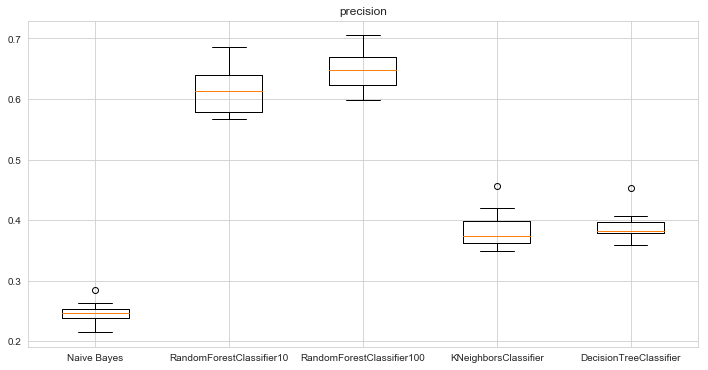

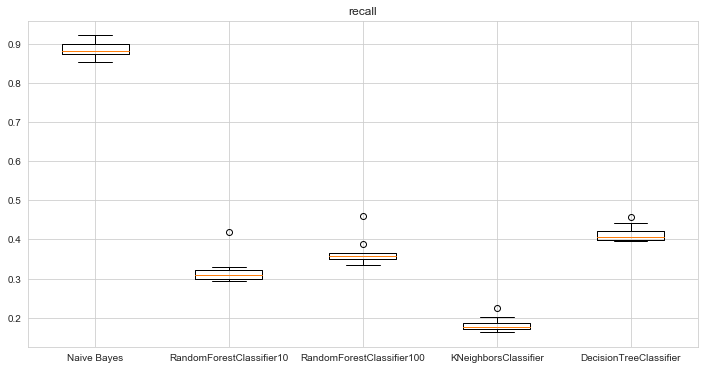

In [10]:
k = 10
results = {}
for m in models:
    print('MODEL', m[0])
    results[m[0]] = {'precision':[], 'recall':[]}
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model = m[1]
        model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        results[m[0]]['precision'].append(precision)
        results[m[0]]['recall'].append(recall)
for metric in ['precision', 'recall']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
    plt.show()

# Tuning the Thresholds

In [11]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
for i in range(1,10):
    print(i)
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred = [1 if x > i/10.0 else 0 for x in y_pred]
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print('Precision', precision)
    print('Recall', recall)

C:\Users\Ary Bressane\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


1
[[ 822 1515]
 [  54  609]]
Precision 0.2867231638418079
Recall 0.918552036199095
2
[[1618  719]
 [ 184  479]]
Precision 0.3998330550918197
Recall 0.722473604826546
3
[[1986  351]
 [ 304  359]]
Precision 0.5056338028169014
Recall 0.5414781297134238
4
[[2143  194]
 [ 368  295]]
Precision 0.6032719836400818
Recall 0.444947209653092
5
[[2215  122]
 [ 426  237]]
Precision 0.6601671309192201
Recall 0.3574660633484163
6
[[2265   72]
 [ 486  177]]
Precision 0.7108433734939759
Recall 0.2669683257918552
7
[[2303   34]
 [ 561  102]]
Precision 0.75
Recall 0.15384615384615385
8
[[2329    8]
 [ 617   46]]
Precision 0.8518518518518519
Recall 0.0693815987933635
9
[[2335    2]
 [ 650   13]]
Precision 0.8666666666666667
Recall 0.0196078431372549
